--- STARTING FINAL QUANTIFICATION (WITH INTENSITY & NASCENT SITE ANALYSIS) ---

Processing condition: DMSO



Processing condition: JQ1

Processing condition: TSA

Final detailed results saved to /home/-Project-Group-B1/results/tables/final_detailed_counts.csv


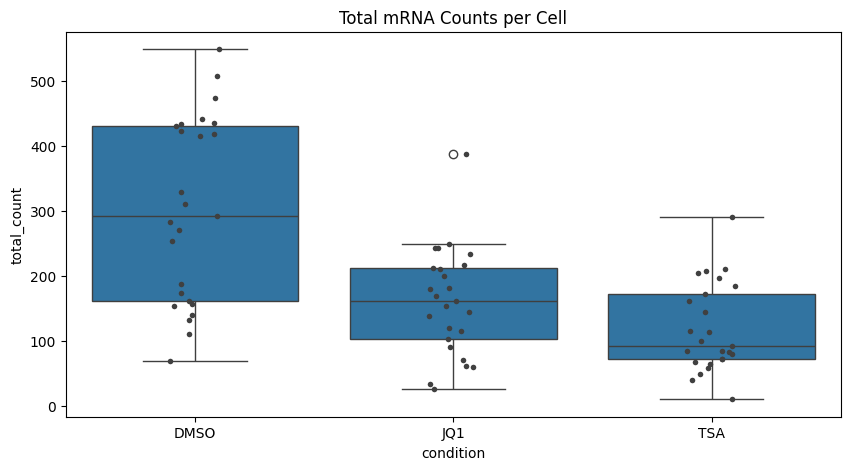


Data Summary:
  condition                                  image  total_count  \
0      DMSO  MCF7_AREG_DMSO_001_ch1_projection.tif          253   
1      DMSO  MCF7_AREG_DMSO_002_ch1_projection.tif          292   
2      DMSO  MCF7_AREG_DMSO_003_ch1_projection.tif          270   
3      DMSO  MCF7_AREG_DMSO_004_ch1_projection.tif          418   
4      DMSO  MCF7_AREG_DMSO_005_ch1_projection.tif          174   

   nascent_count  single_molecule_count  avg_intensity  
0            154                     99       0.408140  
1            212                     80       0.501870  
2            178                     92       0.375847  
3            267                    151       0.466794  
4            130                     44       0.477322  

--- QUANTIFICATION SCRIPT FINISHED ---


In [2]:
import os
import numpy as np
import tifffile
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.feature import blob_log
from skimage import filters

PROJECT_ROOT_PATH = "/home/-Project-Group-B1"

PROCESSED_DIR = os.path.join(PROJECT_ROOT_PATH, "data", "processed")
FINAL_MASKS_DIR = os.path.join(PROJECT_ROOT_PATH, "data", "final_masks")
RESULTS_DIR = os.path.join(PROJECT_ROOT_PATH, "results")
CONDITIONS = ["DMSO", "JQ1", "TSA"]

SIGMA_LIGHT_BLUR = 1.0
SIGMA_HEAVY_BLUR = 10.0
BLOB_MIN_SIGMA = 0.2
BLOB_MAX_SIGMA = 2
BLOB_THRESHOLD = 0.08
NASCENT_SIZE_THRESHOLD = 1.5
NASCENT_INTENSITY_THRESHOLD = 0.1

all_results = []
print("--- STARTING FINAL QUANTIFICATION (WITH INTENSITY & NASCENT SITE ANALYSIS) ---")

for condition in CONDITIONS:
    nuc_mask_dir = os.path.join(FINAL_MASKS_DIR, condition, "CH0_masks")
    cell_mask_dir = os.path.join(FINAL_MASKS_DIR, condition, "CH1_masks")
    fish_image_dir = os.path.join(PROCESSED_DIR, condition, "CH1")

    if not os.path.isdir(cell_mask_dir): continue
    print(f"\nProcessing condition: {condition}")

    for filename in sorted(os.listdir(cell_mask_dir)):
        try:
            fish_image = tifffile.imread(os.path.join(fish_image_dir, filename))
            cell_mask = tifffile.imread(os.path.join(cell_mask_dir, filename))
            nuc_mask = tifffile.imread(os.path.join(nuc_mask_dir, filename.replace('_ch1_', '_ch0_')))
            
            fish_image_float = (fish_image - fish_image.min()) / (fish_image.max() - fish_image.min())
            
            dog_image = filters.gaussian(fish_image_float, sigma=SIGMA_LIGHT_BLUR) - filters.gaussian(fish_image_float, sigma=SIGMA_HEAVY_BLUR)
            blobs = blob_log(dog_image, min_sigma=BLOB_MIN_SIGMA, max_sigma=BLOB_MAX_SIGMA, threshold=BLOB_THRESHOLD)
            
            if len(blobs) == 0:
                all_results.append({'condition': condition, 'image': filename, 'total_count': 0, 'nascent_count': 0, 'single_molecule_count': 0, 'avg_intensity': 0})
                continue

            blob_y = blobs[:, 0].astype(int)
            blob_x = blobs[:, 1].astype(int)
            blob_sigma = blobs[:, 2]

            blob_y = np.clip(blob_y, 0, fish_image_float.shape[0] - 1)
            blob_x = np.clip(blob_x, 0, fish_image_float.shape[1] - 1)
            
            blob_intensities = fish_image_float[blob_y, blob_x]
            avg_intensity = np.mean(blob_intensities)
            
            is_nascent = (blob_sigma > NASCENT_SIZE_THRESHOLD) & (blob_intensities > NASCENT_INTENSITY_THRESHOLD)
            nascent_count = np.sum(is_nascent)
            single_molecule_count = len(blobs) - nascent_count
            
            all_results.append({
                'condition': condition, 'image': filename, 'total_count': len(blobs),
                'nascent_count': nascent_count, 'single_molecule_count': single_molecule_count,
                'avg_intensity': avg_intensity
            })
        except Exception as e:
            print(f"  - FAILED to process {filename}: {e}")

if not all_results:
    print("\nERROR: No data was processed.")
else:
    results_df = pd.DataFrame(all_results)
    output_csv_path = os.path.join(RESULTS_DIR, "tables", 'final_detailed_counts.csv')
    os.makedirs(os.path.dirname(output_csv_path), exist_ok=True)
    results_df.to_csv(output_csv_path, index=False)
    print(f"\nFinal detailed results saved to {output_csv_path}")

    plt.figure(figsize=(10, 5))
    sns.boxplot(data=results_df, x='condition', y='total_count', order=CONDITIONS)
    sns.stripplot(data=results_df, x='condition', y='total_count', order=CONDITIONS, color='0.25', size=4)
    plt.title('Total mRNA Counts per Cell')
    plt.show()

    print("\nData Summary:")
    print(results_df.head())
    
print("\n--- QUANTIFICATION SCRIPT FINISHED ---")